In [2]:
import pandas as pd
import numpy as np
import os
from os.path import isfile, join
import matplotlib.pyplot as plt

import trPL_importClass

In [3]:
TRPL_folderpath = '/home/qrb/Documents/PhD/Experimental/Group1: CsPI MAPI CsFAPI/trPLtrSPV/251015-Jülich-GlassAloxCsFAPI/2025 10 15 TRPL Maxim/BS'

In [4]:
os.listdir(TRPL_folderpath)

['M02t16-BS_3826-43000ns_300nsGate.asc',
 'M02t16-BS_80p3-835ns_2p5nsGate_dark.sif',
 'M02t16_24000-85700ns_2500nsGate_dark.asc',
 'M02t16-BS_638-5583ns_20nsGate.asc',
 'M02t16-BS_11p0-115ns_1p9nsGate_dark.asc',
 'M02t16-BS_80p3-835ns_2p5nsGate_dark.asc',
 'M02t16_3826-43000ns_300nsGate_dark.asc',
 'M02t16-BS_24000-85700ns_2500nsGate.asc',
 'M02t16-BS_11p0-115ns_1p9nsGate.sif',
 'M02t16-BS_638-5583ns_20nsGate_dark.sif',
 'M02t16-BS_80p3-835ns_2p5nsGate.asc',
 'M02t16-BS_24000-85700ns_2500nsGate.sif',
 'M02t16-BS_80p3-835ns_2p5nsGate.sif',
 'M02t16-BS_11p0-115ns_1p9nsGate_dark.sif',
 'M02t16-BS_638-5583ns_20nsGate_dark.asc',
 'M02t16-BS_3826-43000ns_300nsGate.sif',
 'M02t16-BS_638-5583ns_20nsGate.sif',
 'M02t16-BS_11p0-115ns_1p9nsGate.asc']

In [60]:
class trPL_withSpectra:
    def __init__(self, TRPL_folderpath):
        self.TRPL_folderpath = TRPL_folderpath
        self.TRPL_spcts_folder_read()
        self.generateData()
        self.stitch_trPL()
    
    def TRPL_spcts_folder_read(self):
        files = [f for f in os.listdir(self.TRPL_folderpath) if (isfile(join(self.TRPL_folderpath, f)) and f.endswith(".asc") and not(f.endswith("dark.asc")))]
        files = np.array(files)
        
        delay0s = np.zeros((len(files),))
        for i, f in enumerate(files):
            delay0s[i] = (float(f.split("_")[1].split("-")[0].replace("p", ".")))
        inds = delay0s.argsort()
        self.delay0s = delay0s[inds]
        self.files = files[inds]
    

        files_dark = [f for f in os.listdir(self.TRPL_folderpath) if (isfile(join(self.TRPL_folderpath, f)) and f.endswith("dark.asc"))]
        files_dark = np.array(files_dark)
        delay0s_dark = np.zeros((len(files),))
        for i, f in enumerate(files_dark):
            delay0s_dark[i] = (float(f.split("_")[1].split("-")[0].replace("p", ".")))
        inds = delay0s_dark.argsort()
        self.delay0s_dark = delay0s_dark[inds]
        self.files_dark = files_dark[inds]

    def generateData(self):
        
        preamble_dfs = []
        step_list = []
        trPLs_integral = []
        spectraCounts_list = []
        spectraWLs_list = []
        for i, f in enumerate(self.files):
            print("File", f)
            print("--- Dark", self.files_dark[i])
            # Measurement Meta-Data
            df_preamble = pd.read_csv(join(self.TRPL_folderpath, f), nrows=36, header=None, dtype=str, delimiter = '\t')
            preamble_dfs.append(df_preamble)
            time_step = 1e-12*float(df_preamble.iloc[32][0].split()[-1].split('exp')[0]) #s
            exp_factor = float(df_preamble.iloc[32][0].split()[-1].split('exp')[1][1:-2])
            gate_delay0 = 1e-9*float(df_preamble.iloc[31][0].split()[-1]) #ns
            len_series = int(df_preamble.iloc[9][0].split()[-1])

            # trPL Data
            df2 = pd.read_csv(join(self.TRPL_folderpath, f), header=36, delimiter = '\t', names=['lambdas', 'acc-counts'],  index_col=False)
            ls = df2['lambdas'].to_numpy()
            counts = df2['acc-counts'].to_numpy()
            diff = ls[1:]-ls[:-1]
            len_ls = np.argwhere(diff < 0)[0][0]+1
            #background
            bg = pd.read_csv(join(self.TRPL_folderpath, self.files_dark[i]), header=33, delimiter = '\t', names=['lambdas', 'acc-counts'],  index_col=False)

            trPL = np.zeros((len_series,))
            spectraCounts_denoised = np.zeros((len_series,len_ls))
            spectraWLs = np.zeros((len_series,len_ls))
            step_id = np.arange(len_series)
            steps = np.zeros_like(step_id, dtype=float)
            for j in step_id:
                if not(j):
                    steps[j] = gate_delay0
                else:
                    #print(steps[j-2] +  time_step*np.exp(exp_factor*i))
                    steps[j] = steps[j-1] +  time_step*np.exp(exp_factor*j)
                    
                trPL[j] = np.trapezoid(counts[j*len_ls:(j+1)*len_ls] - bg['acc-counts'], x = ls[j*len_ls:(j+1)*len_ls])
                spectraCounts_denoised[j, :] = counts[j*len_ls:(j+1)*len_ls] - bg['acc-counts']
                spectraWLs[j, :] = ls[j*len_ls:(j+1)*len_ls]
                plt.plot(ls[j*len_ls:(j+1)*len_ls], bg['acc-counts'])
                #plt.plot(ls[i*len_ls:(i+1)*len_ls], counts[i*len_ls:(i+1)*len_ls])

            trPLs_integral.append(trPL)
            step_list.append(steps)
            spectraCounts_list.append(spectraCounts_denoised)
            spectraWLs_list.append(spectraWLs)

        self.trPLs_integral = trPLs_integral
        self.step_list = step_list
        self.spectraCounts_list = spectraCounts_list
        self.spectraWLs_list = spectraWLs_list

    def stitch_trPL(self):
        
        stitch_t = np.array([])
        stitch_trPL = np.array([])
        scale = 1
        for i, (t, trPL) in enumerate(zip(self.step_list, self.trPLs_integral)):
            stitch_t = np.concatenate((stitch_t, t))
            if i:
                arg = np.argmin(np.abs(self.step_list[i-1] - t[0]))
                scale = scale*self.trPLs_integral[i-1][arg]/np.amax(self.trPLs_integral[i-1])
            stitch_trPL = np.concatenate((stitch_trPL, scale*trPL/np.amax(trPL)))

        self.stitch_t = stitch_t
        self.stitch_trPL = stitch_trPL


        # Stitch all the spectras and scale them appropriately
        max_len = max((a.shape[1] for a in self.spectraWLs_list), default=0)        #Get maximum length of the WL array
        stitch_spectraCounts = np.full((len(stitch_t), max_len), np.nan)
        stitch_spectraWLs = np.full((len(stitch_t), max_len), np.nan)
        print("Max len", max_len)
        scale = 1.0
        fill_i = 0
        for i, (t, wls, counts) in enumerate(zip(self.step_list, self.spectraWLs_list, self.spectraCounts_list)):
            print(np.amax(counts), np.amax(counts[0]))
            counts = counts/np.amax(counts)
            if i:
                arg = np.argmin(np.abs(self.step_list[i-1] - t[0]))
                scale = scale*np.amax(self.spectraCounts_list[i-1][arg])/np.amax(self.spectraCounts_list[i-1])
            counts = scale*counts
            for j, (wl, count) in enumerate(zip(wls, counts)):
                stitch_spectraWLs[fill_i, :wl.size] = wl
                stitch_spectraCounts[fill_i, :count.size] = count
                fill_i += 1

        self.stitch_spectraWLs = stitch_spectraWLs
        self.stitch_spectraCounts = stitch_spectraCounts
            


        #Get the change in center of mass in function of time
        hc = 1.24e-6
        for i, (wls, spcts) in enumerate(zip(self.spectraWLs_list, self.spectraCounts_list)):
            if not(i):
                max_E = np.zeros((len(wls),))

                integral_L = np.zeros((len(wls),))
                integral_R = np.zeros((len(wls),))

                CoM = np.zeros((len(wls),))

                for j, (wl, spct) in enumerate(zip(wls, spcts)):
                    
                    E = 1240/wl
                    max_E[j] = E[np.argmax((hc/E**2)*spct)]

                    select_L = (E > 1.45) & (E<1.52)
                    integral_L[j] = np.trapezoid((hc/E[select_L]**2)*spct[select_L], x = E[select_L])
                    select_R = (E > 1.57) & (E<1.64) #same size
                    integral_R[j] = np.trapezoid((hc/E[select_R]**2)*spct[select_R], x = E[select_R])

                    select_CoM = (E > 1.45) & (E < 1.8)
                    CoM[j] = np.trapezoid(E[select_CoM]*(hc/E[select_CoM]**2)*spct[select_CoM], x = E[select_CoM]) / np.trapezoid((hc/E[select_CoM]**2)*spct[select_CoM], x = E[select_CoM])

            else:
                for j, (wl, spct) in enumerate(zip(wls, spcts)):
                    E = 1240/wl
                    select_L = (E > 1.45) & (E<1.52)
                    select_R = (E > 1.57) & (E<1.64) #same size
                    max_E = np.append(max_E, E[np.argmax((hc/E**2)*spct)])
                    integral_L = np.append(integral_L, np.trapezoid((hc/E[select_L]**2)*spct[select_L], x = E[select_L]))
                    integral_R = np.append(integral_R, np.trapezoid((hc/E[select_R]**2)*spct[select_R], x = E[select_R]))

                    select_CoM = (E > 1.45) & (E < 1.8)
                    CoM = np.append(CoM, np.trapezoid(E[select_CoM]*(hc/E[select_CoM]**2)*spct[select_CoM], x = E[select_CoM])/np.trapezoid((hc/E[select_CoM]**2)*spct[select_CoM], x = E[select_CoM]))
                    # if not(j%5):
                    #     plt.plot(E, (hc/E**2)*spct)
                # plt.yscale("log")
                # plt.show()

        self.ratioLoverR_spectras = integral_L/integral_R
        self.CoM_spectras = CoM
        

In [6]:
SPV_folderpath = "/home/qrb/Documents/PhD/Experimental/Group1: CsPI MAPI CsFAPI/trPLtrSPV/251015-Jülich-GlassAloxCsFAPI/2025 10 15 trSPV Maxim/All/FS"

files = [f for f in os.listdir(SPV_folderpath) if (isfile(join(SPV_folderpath, f)) and f.endswith("txt") and f.startswith("C3"))]
measurementPos = np.zeros((len(files),))
for i, f in enumerate(files):
    a = 100*float((f.split("_")[0].split("-")[-1][3:4]))
    b = 0
    if ((f.split("_")[0].split("-")[-1][0:2]) == 'EO'):
        b = 50
    c = 0
    if ((f.split("_")[0].split("-")[-2]) == 'Long'):
        c =10
    measurementPos[i] = a+b+c

inds = measurementPos.argsort()
files = np.array(files)
files  = files[inds]
measurementPos = measurementPos[inds]

SPV_folderpathBS = "/home/qrb/Documents/PhD/Experimental/Group1: CsPI MAPI CsFAPI/trPLtrSPV/251015-Jülich-GlassAloxCsFAPI/2025 10 15 trSPV Maxim/All/BS"

files_BS = [f for f in os.listdir(SPV_folderpathBS) if (isfile(join(SPV_folderpathBS, f)) and f.endswith("txt") and f.startswith("C3"))]
measurementPos = np.zeros((len(files_BS),))
for i, f in enumerate(files_BS):
    a = 100*float((f.split("_")[0].split("-")[-1][3:]))
    b = 0
    if ((f.split("_")[0].split("-")[-1][0:2]) == 'EO'):
        b = 50
    c = 0
    if ((f.split("_")[0].split("-")[-2]) == 'Long'):
        c =10
    measurementPos[i] = a+b+c

inds = measurementPos.argsort()
files_BS = np.array(files_BS)
files_BS  = files_BS[inds]
measurementPos = measurementPos[inds]

In [7]:
import matplotlib
from matplotlib import cm

C3--M02t16-FS-Short-SOM0_343nmLaser-100Hz-C3SPV-C4trigger-50Ohm-1000sweeps--00000.txt 7.55e-08 24152
C3--M02t16-FS-Short-EOM0_343nmLaser-100Hz-C3SPV-C4trigger-50Ohm-1000sweeps--00000.txt 7.549999988e-08 160152
C3--M02t16-FS-Short-SOM1_343nmLaser-100Hz-C3SPV-C4trigger-50Ohm-1000sweeps--00000.txt 7.54999997e-08 186152
C3--M02t16-FS-Short-SOM2_343nmLaser-100Hz-C3SPV-C4trigger-50Ohm-1000sweeps--00000.txt 7.54999997e-08 186152
C3--M02t16-FS-Short-EOM3_343nmLaser-100Hz-C3SPV-C4trigger-50Ohm-1000sweeps--00000.txt 7.55e-08 16152
C3--M02t16-FS-Short-EOM4_343nmLaser-100Hz-C3SPV-C4trigger-50Ohm-1000sweeps--00001.txt 7.55e-08 130152
C3--M02t16-FS-Short-EOM5_343nmLaser-100Hz-C3SPV-C4trigger-50Ohm-1000sweeps--00000.txt 7.60000001e-08 65077
C3--M02t16-FS-Short-EOM6_343nmLaser-100Hz-C3SPV-C4trigger-50Ohm-1000sweeps--00000.txt 7.55e-08 130152
C3--M02t16-BS-Short-SOM7_343nmLaser-20Hz-C3SPV-C4trigger-50Ohm-1000sweeps--00000.txt 7.55e-08 76152
C3--M02t16-BS-Long-SOM7_343nmLaser-20Hz-C3SPV-C4trigger-50Ohm-

/home/qrb/miniconda3/envs/optimpv-env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/qrb/miniconda3/envs/optimpv-env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


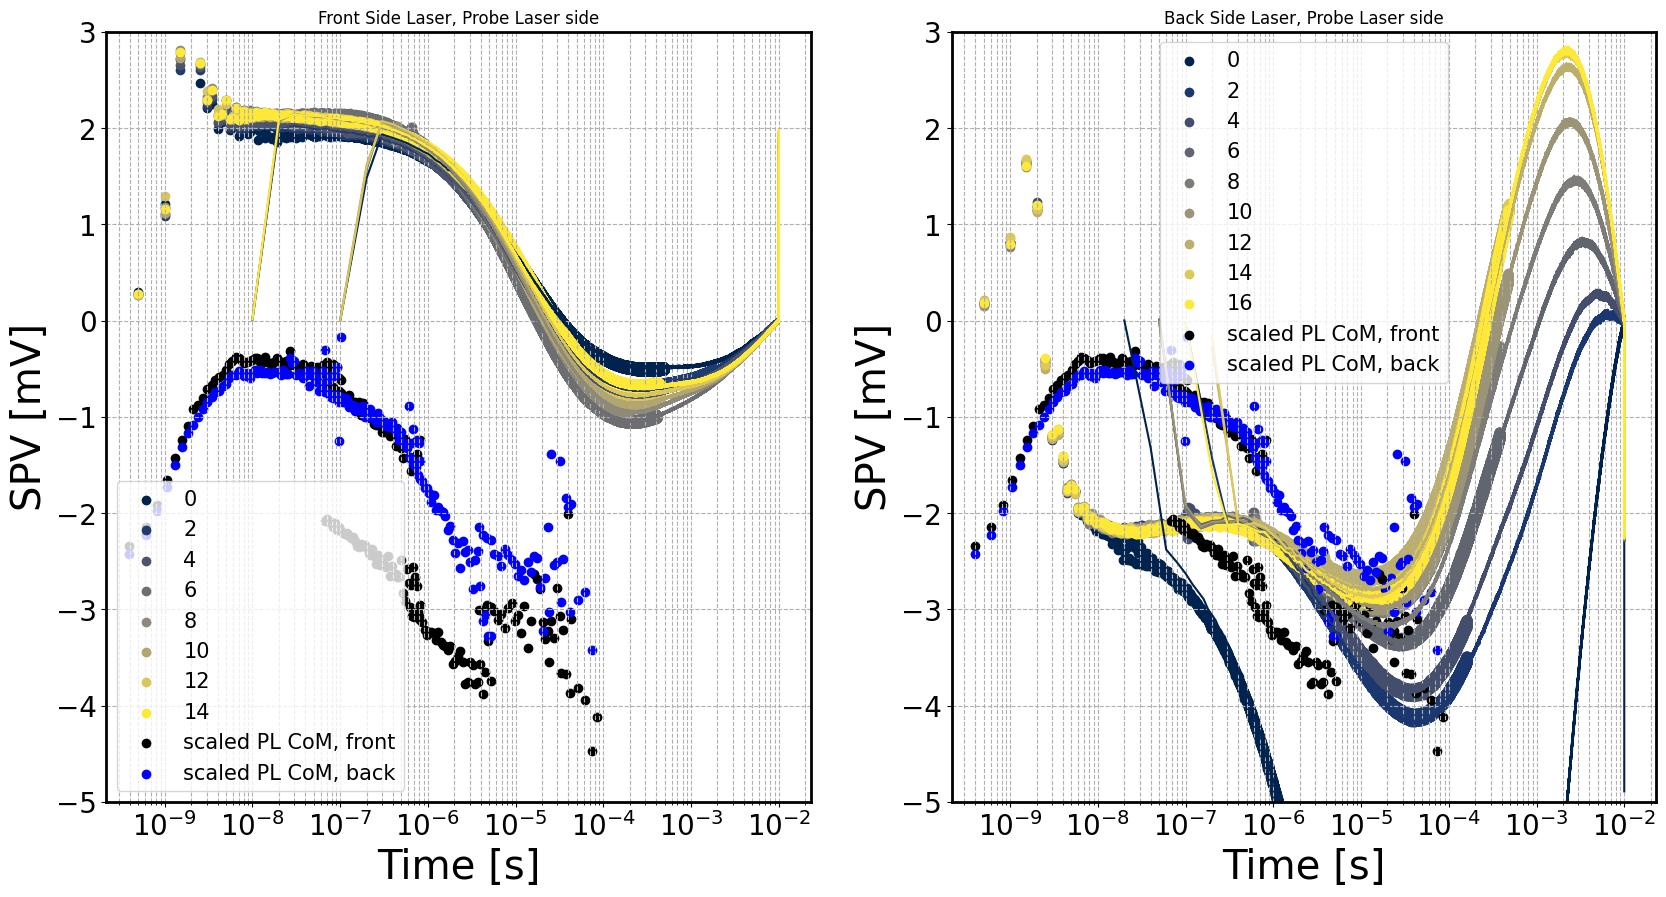

In [13]:
cmap = plt.get_cmap('cividis', int(len(files)/2))          # discrete palette with n colors
colors = [cmap(i) for i in range(int(len(files)/2))]

fig, ax = plt.subplots(1, 2, figsize = (20, 10))

for i, f in enumerate(files):
    if not(measurementPos[i] % 50):
        filepath = join(SPV_folderpath, f)
        spv = pd.read_csv(filepath, skiprows=3, sep = ",", comment='#', dtype=np.float64)
        sig = spv['Ampl'].to_numpy() - np.average(spv['Ampl'].to_numpy()[0:100])
        arg_delay = np.argmax(sig > 1e-4)
        print(f, spv['Time'].to_numpy()[arg_delay], arg_delay)
        t = spv['Time'].to_numpy()-spv['Time'].to_numpy()[arg_delay-1]
        p = ax[0].scatter(t[t>0], 1e3*sig[t>0], label = i, color = colors[int(i/2)])

    else:
        filepath = join(SPV_folderpath, f)
        spv = pd.read_csv(filepath, skiprows=3, sep = ",", comment='#', dtype=np.float64)
        # grab the last scatter (last PathCollection in ax.collections)
        last_scatter = [c for c in ax[0].collections if isinstance(c, matplotlib.collections.PathCollection)][-1]
        sig = spv['Ampl'].to_numpy()
        t = (spv['Time'].to_numpy() - spv['Time'].to_numpy()[0])
        arg = np.argmax(sig[1:]-sig[:-1])
        t = t-t[arg-1]
        ax[0].plot(t[(t>0) & (t<1e-2)], 1e3*(sig[(t>0) & (t<1e-2)] - sig[arg-1]), color = last_scatter.get_facecolors())


cmap = plt.get_cmap('cividis', int(len(files_BS)/2))          # discrete palette with n colors
colors = [cmap(i) for i in range(int(len(files_BS)/2))]

for i, f in enumerate(files_BS):
    if not(measurementPos[i] % 50):
        filepath = join(SPV_folderpathBS, f)
        spv = pd.read_csv(filepath, skiprows=3, sep = ",", comment='#', dtype=np.float64)
        sig = spv['Ampl'].to_numpy() - np.average(spv['Ampl'].to_numpy()[0:100])
        arg_delay = np.argmax(sig > 1e-4)
        print(f, spv['Time'].to_numpy()[arg_delay], arg_delay)
        t = spv['Time'].to_numpy()-spv['Time'].to_numpy()[arg_delay-1]
        p = ax[1].scatter(t[t>0], 1e3*sig[t>0], label = i, color = colors[int(i/2)])
    else:
        filepath = join(SPV_folderpathBS, f)
        spv = pd.read_csv(filepath, skiprows=3, sep = ",", comment='#', dtype=np.float64)
        # grab the last scatter (last PathCollection in ax.collections)
        last_scatter = [c for c in ax[1].collections if isinstance(c, matplotlib.collections.PathCollection)][-1]
        sig = spv['Ampl'].to_numpy()
        t = (spv['Time'].to_numpy() - spv['Time'].to_numpy()[0])
        arg = np.argmin(sig[1:]-sig[:-1])
        t = t-t[arg-1]
        print(f, spv['Time'].to_numpy()[arg_delay], arg_delay)
        ax[1].plot(t[(t>0) & (t<1e-2)], 1e3*(sig[(t>0) & (t<1e-2)] - sig[arg-1]), color = last_scatter.get_facecolors())

ax[0].scatter(trPLs.stitch_t-trPLs.stitch_t[np.argmax(trPLs.stitch_trPL)], 2*(trPLs.CoM_spectras - trPLs.CoM_spectras[0])/0.005, label = "scaled PL CoM, front", color = "black")
ax[0].scatter(trPLs_BS.stitch_t-trPLs_BS.stitch_t[np.argmax(trPLs_BS.stitch_trPL)], 2*(trPLs_BS.CoM_spectras - trPLs_BS.CoM_spectras[0])/0.005, label = "scaled PL CoM, back", color = "blue")

ax[1].scatter(trPLs.stitch_t-trPLs.stitch_t[np.argmax(trPLs.stitch_trPL)], 2*(trPLs.CoM_spectras - trPLs.CoM_spectras[0])/0.005, label = "scaled PL CoM, front", color = "black")
ax[1].scatter(trPLs_BS.stitch_t-trPLs_BS.stitch_t[np.argmax(trPLs_BS.stitch_trPL)], 2*(trPLs_BS.CoM_spectras - trPLs_BS.CoM_spectras[0])/0.005, label = "scaled PL CoM, back", color = "blue")

ax[0].set_title("Front Side Laser, Probe Laser side")
ax[1].set_title("Back Side Laser, Probe Laser side")

for a in ax:
    a.set_xscale("log")
    a.set_yscale("linear")
    a.set_ylim([-5, 3])

    axis_fontsize = 29
    axisTicks_fontsize = 20
    a.legend(fontsize = 15)
    a.set_ylabel("SPV [mV]", size = axis_fontsize)
    a.set_xlabel("Time [s]", size = axis_fontsize)
    a.tick_params(axis='x', labelsize=axisTicks_fontsize)
    a.tick_params(axis='y', labelsize=axisTicks_fontsize)
    a.grid(visible = True, which = 'both', linestyle = '--')

    w_frame = 2
    a.spines["bottom"].set_linewidth(w_frame)
    a.spines["top"].set_linewidth(w_frame)
    a.spines["left"].set_linewidth(w_frame)
    a.spines["right"].set_linewidth(w_frame)

In [338]:
SPV_folderpath = "/home/qrb/Documents/PhD/Experimental/Group1: CsPI MAPI CsFAPI/trPLtrSPV/251015-Jülich-GlassAloxCsFAPI/2025 10 15 trSPV Maxim/All/BS"

files = [f for f in os.listdir(SPV_folderpath) if (isfile(join(SPV_folderpath, f)) and f.endswith("txt") and f.startswith("C3"))]
measurementPos = np.zeros((len(files),))
for i, f in enumerate(files):
    a = 100*float((f.split("_")[0].split("-")[-1][3:]))
    b = 0
    if ((f.split("_")[0].split("-")[-1][0:2]) == 'EO'):
        b = 50
    c = 0
    if ((f.split("_")[0].split("-")[-2]) == 'Long'):
        c =10
    print((f.split("_")[0].split("-")[-1][3:]), a+b+c)

    measurementPos[i] = a+b+c

inds = measurementPos.argsort()
files = np.array(files)
files  = files[inds]
measurementPos = measurementPos[inds]

9 910.0
7 700.0
9 960.0
12 1200.0
10 1050.0
10 1010.0
10 1060.0
11 1150.0
11 1100.0
10 1000.0
11 1160.0
7 710.0
9 900.0
11 1110.0
9 950.0
8 860.0
12 1210.0
8 850.0


C3--M02t16-FS-Short-SOM0_343nmLaser-100Hz-C3SPV-C4trigger-50Ohm-1000sweeps--00000.txt 7.55e-08 24152
C3--M02t16-FS-Long-SOM0_343nmLaser-100Hz-C3SPV-C4trigger-50Ohm-1000sweeps--00001.txt -0.0015849 24152


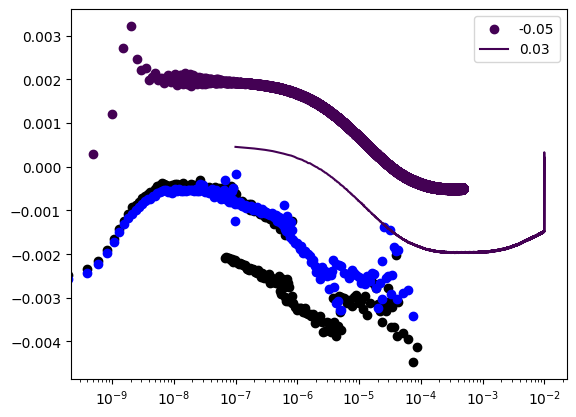

In [359]:
cmap = plt.get_cmap('viridis', int(len(files)/2))          # discrete palette with n colors
colors = [cmap(i) for i in range(int(len(files)/2))]

for i, f in enumerate(files):
    if (i>1):
        break
    if not(measurementPos[i] % 50):
        filepath = join(SPV_folderpath, f)
        spv = pd.read_csv(filepath, skiprows=3, sep = ",", comment='#', dtype=np.float64)
        sig = spv['Ampl'].to_numpy() - np.average(spv['Ampl'].to_numpy()[0:100])
        arg_delay = np.argmax(sig > 1e-4)
        print(f, spv['Time'].to_numpy()[arg_delay], arg_delay)
        t = spv['Time'].to_numpy()-spv['Time'].to_numpy()[arg_delay-1]
        p = plt.scatter(t[t>0], sig[t>0], label = i, color = colors[int(i/2)])
    else:
        filepath = join(SPV_folderpath, f)
        spv = pd.read_csv(filepath, skiprows=3, sep = ",", comment='#', dtype=np.float64)
        # grab the last scatter (last PathCollection in ax.collections)
        last_scatter = [c for c in plt.gca().collections if isinstance(c, matplotlib.collections.PathCollection)][-1]
        sig = spv['Ampl'].to_numpy()
        t = (spv['Time'].to_numpy() - spv['Time'].to_numpy()[0])
        arg = np.argmin(sig[1:]-sig[:-1])
        t = t-t[arg-1]
        print(f, spv['Time'].to_numpy()[arg_delay], arg_delay)
        plt.plot(t[(t>0) & (t<1e-2)], sig[(t>0) & (t<1e-2)] - sig[arg-1], color = last_scatter.get_facecolors())

plt.xscale("log")
plt.yscale("linear")
plt.legend([-0.05, 0.03])

plt.scatter(trPLs.stitch_t-trPLs.stitch_t[np.argmax(trPLs.stitch_trPL)], 0.002*(trPLs.CoM_spectras - trPLs.CoM_spectras[0])/0.005, label = "CoM PL, front", color = "black")
plt.scatter(trPLs_BS.stitch_t-trPLs_BS.stitch_t[np.argmax(trPLs_BS.stitch_trPL)], 0.002*(trPLs_BS.CoM_spectras - trPLs_BS.CoM_spectras[0])/0.005, label = "CoM PL, back", color = "blue")
#plt.xlim("")

C3--M02t16-BS-Short-EOM8_343nmLaser-100Hz-C3SPV-C4trigger-50Ohm-1000sweeps--00001.txt -3.7506e-05 989


/tmp/ipykernel_401/2899691172.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


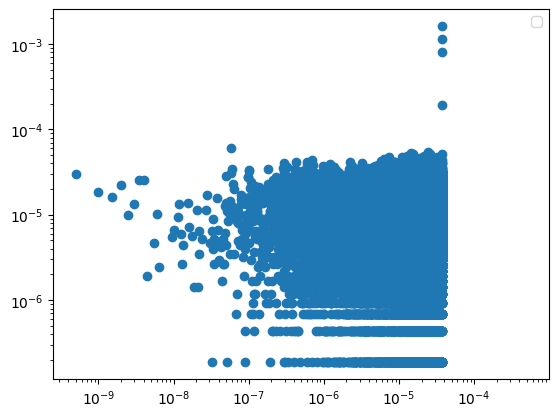

In [325]:
filepath = join(SPV_folderpath, files[0])
spv = pd.read_csv(filepath, skiprows=3, sep = ",", comment='#', dtype=np.float64)
sig = spv['Ampl'].to_numpy() - np.average(spv['Ampl'].to_numpy()[0:100])
arg_delay = np.argmax(sig > 4e-5)
print(f, spv['Time'].to_numpy()[arg_delay], arg_delay)
t = spv['Time'].to_numpy()-spv['Time'].to_numpy()[arg_delay]
p = plt.scatter(t[t>0], sig[t>0])

plt.xscale("log")
plt.yscale("log")
plt.legend()

-0.00148364 1819


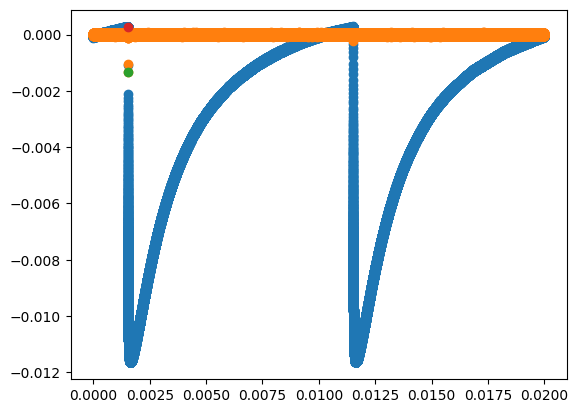

In [329]:
filepath = join(SPV_folderpath, files[1])
spv = pd.read_csv(filepath, skiprows=3, sep = ",", comment='#', dtype=np.float64)


arg0 = 24150
sig = spv['Ampl'].to_numpy()
t = (spv['Time'].to_numpy() - spv['Time'].to_numpy()[0])
plt.scatter(t, spv['Ampl'].to_numpy() - 0.003)
plt.scatter((t)[:-1], sig[1:]-sig[:-1])
arg = np.argmin(sig[1:]-sig[:-1])
plt.scatter((t)[arg], (sig[1:]-sig[:-1])[arg])
plt.scatter((t)[arg-1], sig[arg-1]- 0.003)

plt.xscale("linear")
plt.yscale("linear")
#plt.xlim([3.975e-3,4.025e-3])

sig = spv['Ampl'].to_numpy() - np.average(spv['Ampl'].to_numpy()[0:100])
arg_delay = np.argmax(sig > 5e-5)
print(spv['Time'].to_numpy()[arg_delay], arg_delay)
#plt.scatter(spv['Time'].to_numpy()-spv['Time'].to_numpy()[arg_delay-10], spv['Ampl'].to_numpy() - np.average(spv['Ampl'].to_numpy()[0:100]))

t = spv['Time'].to_numpy()

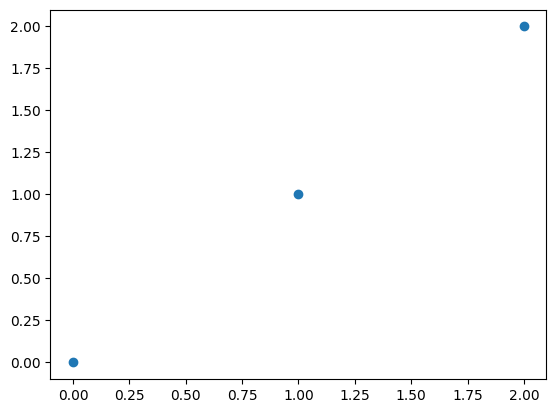

In [33]:
plt.scatter(np.array([0, 1, 2, np.nan, np.nan]), np.array([0, 1, 2, np.nan, np.nan]))

File M02t16_11p0-115ns_1p9nsGate.asc
--- Dark M02t16_11p0-115ns_1p9nsGate_dark.asc
File M02t16_80p3-835ns_2p5nsGate_nextDay.asc
--- Dark M02t16_80p3-835ns_2p5nsGate(copy)_dark.asc
File M02t16_80p3-835ns_2p5nsGate.asc
--- Dark M02t16_80p3-835ns_2p5nsGate_dark.asc
File M02t16_638-5191ns_20nsGate.asc
--- Dark M02t16_638-5191ns_20nsGate_dark.asc
File M02t16_3826-43000ns_300nsGate.asc
--- Dark M02t16_3826-43000ns_300nsGate_dark.asc
File M02t16_24000-85700ns_2500nsGate.asc
--- Dark M02t16_24000-85700ns_2500nsGate_dark.asc
Max len 204
11548367.0 39704.0
7733374.0 7733374.0
7731622.0 7731622.0
10038129.0 10038129.0
9052742.0 9052742.0
5058388.0 5058388.0


array(['M02t16_11p0-115ns_1p9nsGate.asc',
       'M02t16_80p3-835ns_2p5nsGate_nextDay.asc',
       'M02t16_80p3-835ns_2p5nsGate.asc',
       'M02t16_638-5191ns_20nsGate.asc',
       'M02t16_3826-43000ns_300nsGate.asc',
       'M02t16_24000-85700ns_2500nsGate.asc'], dtype='<U39')

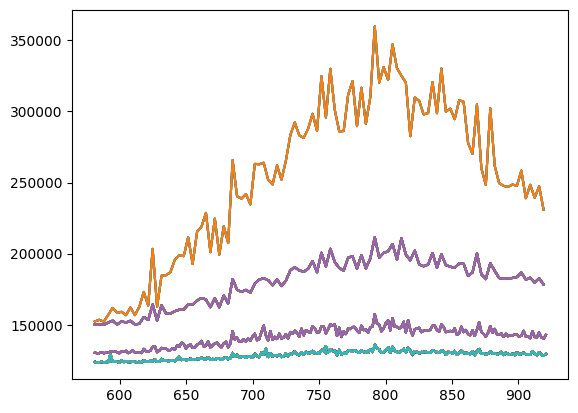

In [61]:
TRPL_folderpath = "/home/qrb/Documents/PhD/Experimental/Group1: CsPI MAPI CsFAPI/trPLtrSPV/251015-Jülich-GlassAloxCsFAPI/2025 10 15 TRPL Maxim/FS"
trPLs = trPL_withSpectra(TRPL_folderpath)
trPLs.files

File M02t16-BS_11p0-115ns_1p9nsGate.asc
--- Dark M02t16-BS_11p0-115ns_1p9nsGate_dark.asc
File M02t16-BS_80p3-835ns_2p5nsGate.asc
--- Dark M02t16-BS_80p3-835ns_2p5nsGate_dark.asc
File M02t16-BS_638-5583ns_20nsGate.asc
--- Dark M02t16-BS_638-5583ns_20nsGate_dark.asc
File M02t16-BS_3826-43000ns_300nsGate.asc
--- Dark M02t16_3826-43000ns_300nsGate_dark.asc
File M02t16-BS_24000-85700ns_2500nsGate.asc
--- Dark M02t16_24000-85700ns_2500nsGate_dark.asc
Max len 204
9620304.0 16057.0
7294372.0 7294372.0
9603609.0 9603609.0
8333803.0 8333803.0
4243313.0 4243313.0


array(['M02t16-BS_11p0-115ns_1p9nsGate.asc',
       'M02t16-BS_80p3-835ns_2p5nsGate.asc',
       'M02t16-BS_638-5583ns_20nsGate.asc',
       'M02t16-BS_3826-43000ns_300nsGate.asc',
       'M02t16-BS_24000-85700ns_2500nsGate.asc'], dtype='<U38')

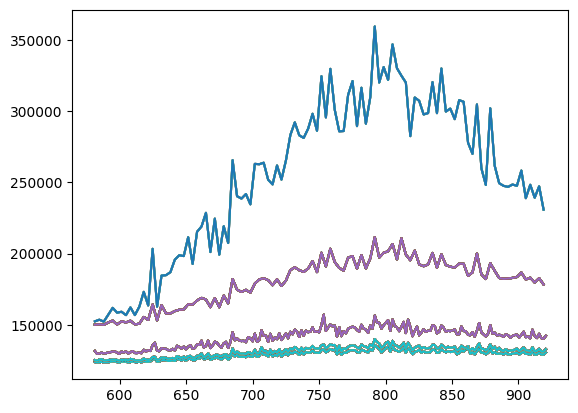

In [62]:
TRPL_folderpath_back = "/home/qrb/Documents/PhD/Experimental/Group1: CsPI MAPI CsFAPI/trPLtrSPV/251015-Jülich-GlassAloxCsFAPI/2025 10 15 TRPL Maxim/BS"
trPLs_BS = trPL_withSpectra(TRPL_folderpath_back)
trPLs_BS.files

/tmp/ipykernel_2598/1652531545.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  a.legend(fontsize = 15)


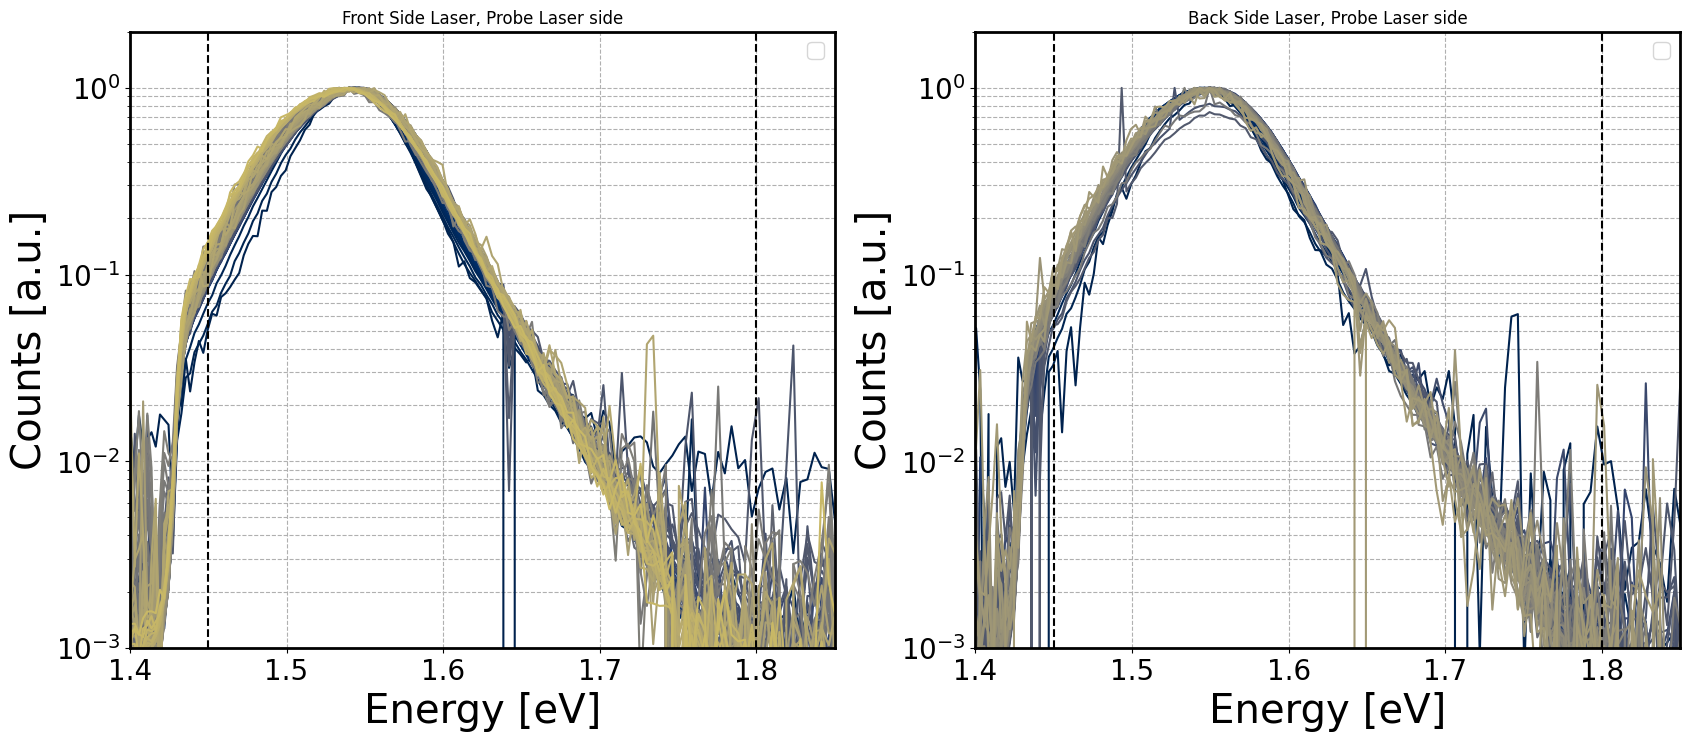

In [67]:
fig, ax = plt.subplots(1,2, figsize = (20, 8))

cmap = plt.get_cmap('cividis', int(len(trPLs.stitch_spectraWLs)/2))          # discrete palette with n colors
colors = [cmap(i) for i in range(int(len(trPLs.stitch_spectraWLs)/2))]
for i, (wls_FS, counts_FS, wls_BS, counts_BS) in enumerate(zip(trPLs.stitch_spectraWLs, trPLs.stitch_spectraCounts, trPLs_BS.stitch_spectraWLs, trPLs_BS.stitch_spectraCounts)):
    if not(i%2):
        hc = 1.24e-6
        EFS = 1240/wls_FS
        ax[0].plot(EFS, (hc/EFS**2)*counts_FS/np.amax((hc/EFS**2)*counts_FS), color = colors[int(i/2)])
        EBS = 1240/wls_BS
        ax[1].plot(EBS, (hc/EBS**2)*counts_BS/np.amax((hc/EBS**2)*counts_BS), color = colors[int(i/2)])

axis_fontsize = 29
axisTicks_fontsize = 20
ax[0].set_title("Front Side Laser, Probe Laser side")
ax[1].set_title("Back Side Laser, Probe Laser side")
for a in ax:
    a.axvline(1.45, linestyle = '--', color = 'black')
    a.axvline(1.8, linestyle = '--', color = 'black')
    a.set_xscale("linear")
    a.set_yscale("log")
    a.set_xlim([1.4, 1.85])
    a.set_ylim([1e-3, 2])
    a.legend(fontsize = 15)
    a.set_ylabel("Counts [a.u.]", size = axis_fontsize)
    a.set_xlabel("Energy [eV]", size = axis_fontsize)
    a.tick_params(axis='x', labelsize=axisTicks_fontsize)
    a.tick_params(axis='y', labelsize=axisTicks_fontsize)
    a.grid(visible = True, which = 'both', linestyle = '--')
    w_frame = 2
    a.spines["bottom"].set_linewidth(w_frame)
    a.spines["top"].set_linewidth(w_frame)
    a.spines["left"].set_linewidth(w_frame)
    a.spines["right"].set_linewidth(w_frame)

/tmp/ipykernel_2598/808523779.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  a.legend(fontsize = 15)


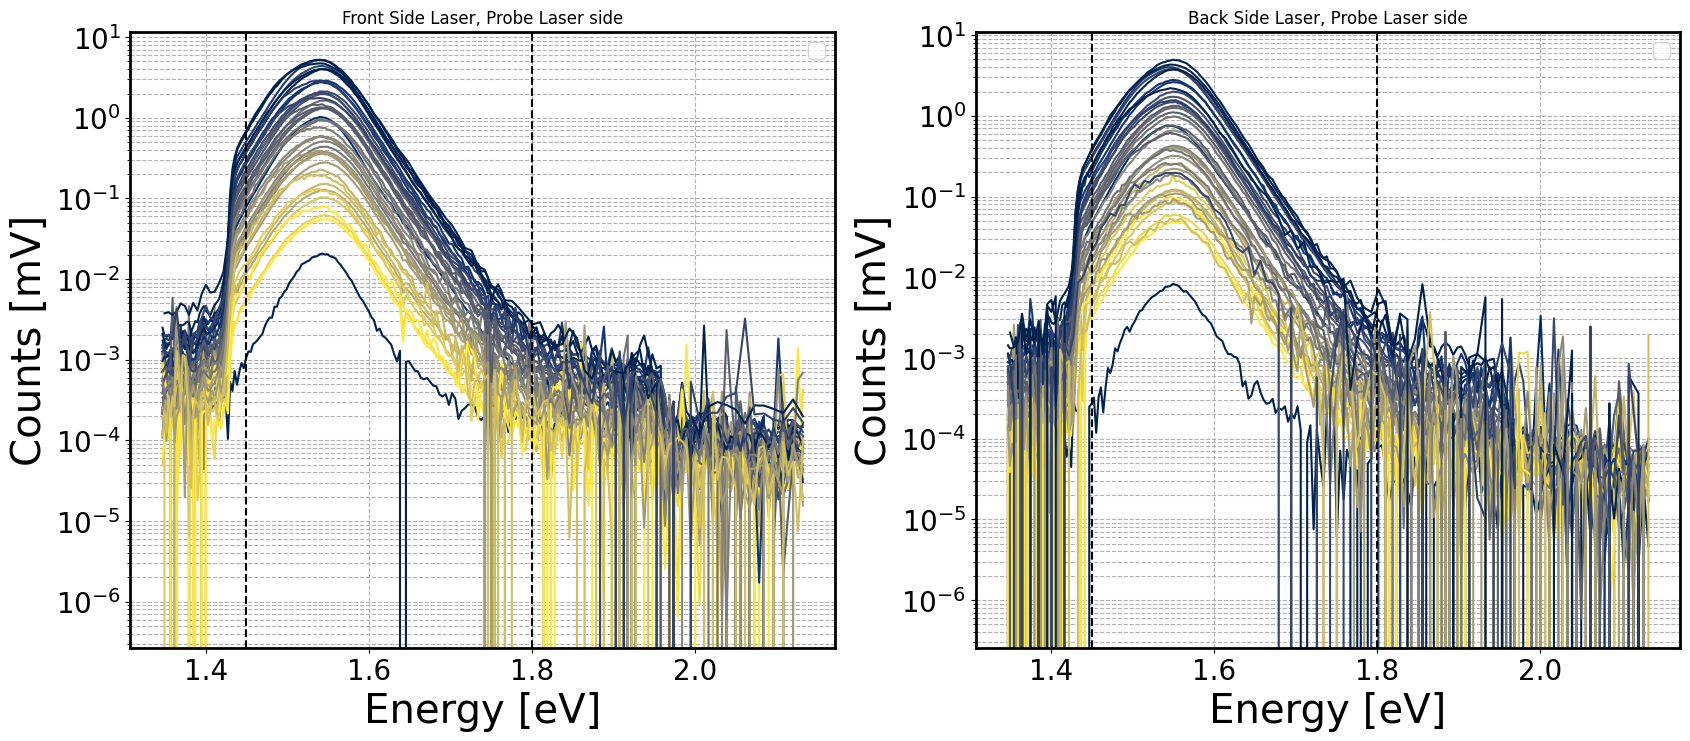

In [27]:
fig, ax = plt.subplots(1,2, figsize = (20, 8))



for i, (wls_FS, counts_FS, wls_BS, counts_BS) in enumerate(zip(trPLs.spectraWLs_list, trPLs.spectraCounts_list, trPLs_BS.spectraWLs_list, trPLs_BS.spectraCounts_list)):
    cmap = plt.get_cmap('cividis', int(len(wls_FS)/5))          # discrete palette with n colors
    colors = [cmap(i) for i in range(int(len(wls_FS)/5))]
    for j, (wlFS, countFS, wlBS, countBS) in enumerate(zip(wls_FS, counts_FS, wls_BS, counts_BS)):
        if not(j%5):
            hc = 1.24e-6
            EFS = 1240/wlFS
            ax[0].plot(EFS, (hc/EFS**2)*countFS, color = colors[int(j/5)])
            EBS = 1240/wlBS
            ax[1].plot(EBS, (hc/EBS**2)*countBS, color = colors[int(j/5)])

axis_fontsize = 29
axisTicks_fontsize = 20
ax[0].set_title("Front Side Laser, Probe Laser side")
ax[1].set_title("Back Side Laser, Probe Laser side")
for a in ax:
    a.axvline(1.45, linestyle = '--', color = 'black')
    a.axvline(1.8, linestyle = '--', color = 'black')
    a.set_xscale("linear")
    a.set_yscale("log")
    #a.set_xlim([])
    a.legend(fontsize = 15)
    a.set_ylabel("Counts [mV]", size = axis_fontsize)
    a.set_xlabel("Energy [eV]", size = axis_fontsize)
    a.tick_params(axis='x', labelsize=axisTicks_fontsize)
    a.tick_params(axis='y', labelsize=axisTicks_fontsize)
    a.grid(visible = True, which = 'both', linestyle = '--')
    w_frame = 2
    a.spines["bottom"].set_linewidth(w_frame)
    a.spines["top"].set_linewidth(w_frame)
    a.spines["left"].set_linewidth(w_frame)
    a.spines["right"].set_linewidth(w_frame)

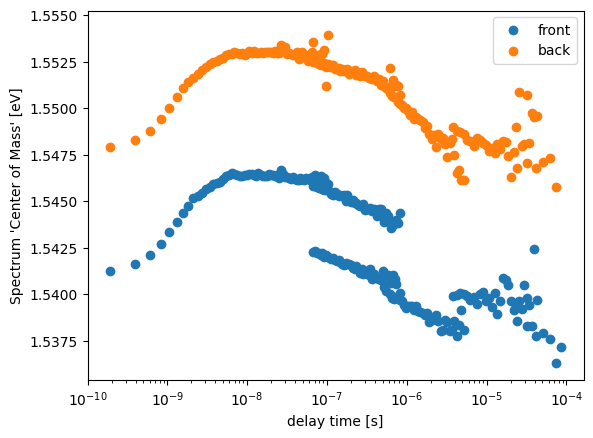

In [11]:
plt.scatter(trPLs.stitch_t-trPLs.stitch_t[np.argmax(trPLs.stitch_trPL)], trPLs.CoM_spectras, label = "front")
plt.scatter(trPLs_BS.stitch_t-trPLs_BS.stitch_t[np.argmax(trPLs_BS.stitch_trPL)], trPLs_BS.CoM_spectras, label = "back")
plt.xscale("log")
plt.ylabel("Spectrum 'Center of Mass' [eV]" )
plt.xlabel("delay time [s]")
plt.legend()

Text(0.5, 0, 'time [s]')

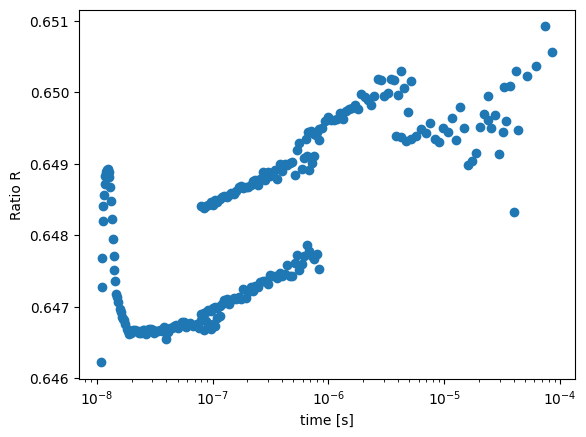

In [94]:
#plt.scatter(trPLs.stitch_t, integral_L/integral_R)
plt.scatter(trPLs.stitch_t, 1/CoM)
plt.xscale("log")
plt.ylabel("Ratio R")
plt.xlabel("time [s]")

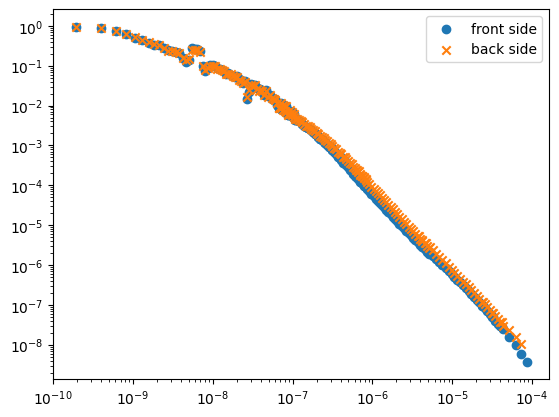

In [12]:
plt.scatter(trPLs.stitch_t - trPLs.stitch_t[np.argmax(trPLs.stitch_trPL)], trPLs.stitch_trPL, label = "front side")
plt.scatter(trPLs_BS.stitch_t - trPLs_BS.stitch_t[np.argmax(trPLs_BS.stitch_trPL)], trPLs_BS.stitch_trPL, label = "back side", marker = "x")
plt.yscale("log")
plt.xscale("log")
plt.legend()